# Signal files
First let's look at the available signal files

In [2]:
%%bash 
export XrdSecGSISRVNAMES=cmseos.fnal.gov
xrdfs root://cmseos.fnal.gov/ ls /store/user/cmsdas/2023/short_exercises/tagging/

/store/user/cmsdas/2023/short_exercises/tagging/BulkGravToZZ_tree.root
/store/user/cmsdas/2023/short_exercises/tagging/BulkGravTohh_tree.root
/store/user/cmsdas/2023/short_exercises/tagging/BulkGravTohh_tree_noc.root
/store/user/cmsdas/2023/short_exercises/tagging/ZprimeToTT_tree.root
/store/user/cmsdas/2023/short_exercises/tagging/ZprimeToWW_tree.root
/store/user/cmsdas/2023/short_exercises/tagging/qcd-pythia_tree.root
/store/user/cmsdas/2023/short_exercises/tagging/qcd-pythia_tree_SLIM.root
/store/user/cmsdas/2023/short_exercises/tagging/qcd-pythia_tree_noc.root


# Open signal files and inspect tree
Let's open the one signal file and one background file and print the contents of the tree

In [3]:
uproot.__version__

'4.3.7'

In [2]:
import uproot

filename_hh = 'root://cmseos.fnal.gov//store/user/cmsdas/2023/short_exercises/tagging/BulkGravTohh_tree_noc.root'
filename_qcd = 'root://cmseos.fnal.gov//store/user/cmsdas/2023/short_exercises/tagging/qcd-pythia_tree_SLIM.root'

uptree_hh = uproot.open(filename_hh)["Friends"]
uptree_qcd = uproot.open(filename_qcd)["Friends"]


/home/cms.kakwok/das2023_hrt/CMSSW_11_1_0_pre5/bin/coffeaenv/lib/python3.6/site-packages/uproot/reading.py:171: FutureWarning: XRootD 4.12.7 is not fully supported; either upgrade to 5.2.0+ or set

    open.defaults["xrootd_handler"] = uproot.MultithreadedXRootDSource

  warnings.warn(message, FutureWarning)


In [8]:
uptree_hh.num_entries

1492191

In [5]:
uptree_hh.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
i_evt                | int32_t                  | AsDtype('>i4')
i_parton             | int32_t                  | AsDtype('>i4')
type                 | int32_t                  | AsDtype('>i4')
npv                  | int32_t                  | AsDtype('>i4')
genweight            | float                    | AsDtype('>f4')
gen_n_b_daus         | int32_t                  | AsDtype('>i4')
gen_n_c_daus         | int32_t                  | AsDtype('>i4')
gen_pt               | float                    | AsDtype('>f4')
gen_eta              | float                    | AsDtype('>f4')
gen_phi              | float                    | AsDtype('>f4')
gen_pdgid            | int32_t                  | AsDtype('>i4')
gen_size             | float                    | AsDtype('>f4')
gentop_b_pt          | float                    | AsDtype(

# Plot tagger distributions
Let's plot each of the different discriminatig variables distributions 

In [26]:
# Read all branches in the tree as method of the event obj.
hh_events = uproot.lazy(uptree_hh)
qcd_events = uproot.lazy(uptree_qcd)

In [ ]:
# all branch names
hh_events.fields

In [24]:
# Selection for hig
def getCut(events):
    cut = (events.gen_pt>1000) & (events.gen_pt<1500) & (abs(events.gen_eta)<2.4) & (events.ak8_sdmass>40) & (events.ak8_sdmass<200)
    return cut

In [29]:
hh_cut  = getCut(hh_events)
qcd_cut = getCut(qcd_events)

In [43]:
# Range of the discriminator
print("min = ",min(getattr(hh_events,"ak8_sdmass")[hh_cut]))
print("max = ",max(getattr(hh_events,"ak8_sdmass")[hh_cut]))

min =  40.00023651123047
max =  199.89378356933594


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

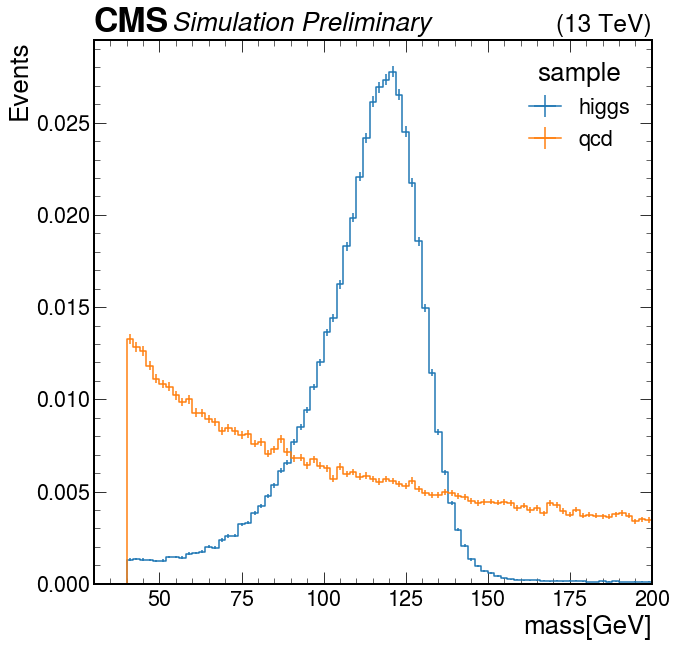

In [44]:
from coffea import hist
import mplhep as hep
hep.set_style(hep.styles.CMS)

tagger = 'ak8_sdmass'
# tagger = 'ak8_tau21'
#tagger = 'ak8_ecfN2'
#tagger = 'ak8_doubleb'
#tagger = 'ak8_nn_HbbvsQCD' # DeepAK8
#tagger = 'ak8_decorr_nn_ZHbbvsQCD' # DeepAK8-MD
#tagger = 'ak8_bestH'

h = hist.Hist("Events",
              hist.Cat("sample","sample"),
              hist.Bin("mass","mass[GeV]",85,30,200))

h.fill(sample="higgs",mass = getattr(hh_events,tagger)[hh_cut])
h.fill(sample="qcd"  ,mass = getattr(qcd_events,tagger)[qcd_cut])
ax = hist.plot1d(h,density=True)
hep.cms.label(ax=ax)

# checkpoint: 
plot the output of the ML-based algorithms: e.g. for the Higgs case for DoubleB, DeepAK8 and DeepAK8-MD. Remember: the tagger score is usually a number between 0 and 1...

In [46]:
## place holder for the checkpoint

# Convert tree to dataframe with `uproot`
Open the file with `uproot` and convert the tree to a `pandas` dataframe.

In [ ]:
import pandas 
## this step may take some time 
branches = ['ak8_nn_HbbvsQCD',
            'ak8_decorr_nn_ZHbbvsQCD',
            'ak8_doubleb',
            'ak8_tau21',
            'ak8_ecfN2',
            'ak8_bestH',
            'ak8_sdmass',
            'ak8_pt',
            'ak8_eta',
            'gen_pt',
            'gen_eta']


print("get hh")
df_hh = uptree_hh.pandas.df(branches=branches+['rewgt'])
#print(df_hh)

print("get QCD")
df_qcd = uptree_qcd.pandas.df(branches=branches+['genweight'])
#print(df_qcd)

# Apply cuts and merge dataframes
Let's apply the same fiducial cuts and merge the signal and background dataframes

In [ ]:
import pandas
import numpy as np

# mask higgs outside of fiducial cuts
mask_hh = (df_hh['gen_pt'] > 1000) & (df_hh['gen_pt'] < 1500) & (np.abs(df_hh['gen_eta']) < 2.4) & (df_hh['ak8_sdmass'] > 40) & (df_hh['ak8_sdmass'] < 200)
df_hh = df_hh[mask_hh]
df_hh['sample_weight'] = df_hh['rewgt']
df_hh['label'] = np.ones((len(df_hh)),dtype=int)

# mask qcd outside of fiducial cuts
mask_qcd = (df_qcd['gen_pt'] > 1000) & (df_qcd['gen_pt'] < 1500) & (np.abs(df_qcd['gen_eta']) < 2.4) & (df_qcd['ak8_sdmass'] > 40) & (df_qcd['ak8_sdmass'] < 200)
df_qcd = df_qcd[mask_qcd]
df_qcd['sample_weight'] = df_qcd['genweight']
df_qcd['label'] = np.zeros((len(df_qcd)),dtype=int)

# concatenate signal and background
df = pandas.concat([df_hh,df_qcd])

# Plot ROCs
Plot the ROC for one of the tagging variables

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline
fpr = {}
tpr = {}
threshold = {}
plt.figure()

tagger = 'ak8_sdmass'
fpr[tagger], tpr[tagger], threshold[tagger] = roc_curve(df['label'], df[tagger], sample_weight=df['sample_weight'])
myauc = auc(fpr[tagger], tpr[tagger],reorder=True)
plt.plot(tpr[tagger],fpr[tagger],label='%s tagger, AUC = %.3f'%(tagger, myauc))

plt.legend(loc='best')
plt.semilogy()
plt.xlim([0, 1])
plt.ylim([1e-4, 1])
plt.xlabel("TPR");
plt.ylabel("FPR");

# checkpoint: 
Compare performance of other tagging algorithms

# Beyond ROC curves: Tagger's response vs. jet mass 
Study the correlation between the tagger's response and the jet mass
Different WP for each algorithm will be provided by the instructor
Discussion: thoughts, ideas, concerns ?

# Train your own simple tagger
Train your own simple tagger with keras

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense

inputs = Input(shape=(2,), name = 'input')  
x = Dense(5, name = 'dense_1', activation = 'relu')(inputs)
outputs = Dense(1, name = 'output', activation='sigmoid')(x)

# creae the model
model = Model(inputs=inputs, outputs=outputs)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

In [ ]:
x = np.vstack([df['ak8_sdmass'], df['ak8_tau21']]).T
print(x.shape)
y = df['label']
print(y.shape)
model.fit(x,y, epochs=1)
df['ak8_sdmass_tau21'] = model.predict(x)

# Exercises
 - Exercise 1. Plot all of the taggers on the same ROC curve
 - Exercise 2. Train your own custom "traditional" tagger based on mSD and tau21
 - Exercise 3. Add your tagger to the ROC curve
 - Exercise 4. Repeat with a different signal sample (W, Z, or top)
 - Exercise 5 [advanced]. Understand the impact of different sets of inputs in the jet classification problem